In [1]:
from __future__ import print_function, division
%matplotlib inline
import matplotlib.pyplot as plt
import sys, os
import numpy as np

In [2]:
import keras # Only imported keras to use the mnist dataset.
import tensorflow as tf

Using TensorFlow backend.


In [3]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [4]:
# Convert to float datatype.
X_train = X_train.astype(np.float32)

# Normalize so the max value is 1.
X_train /= 255

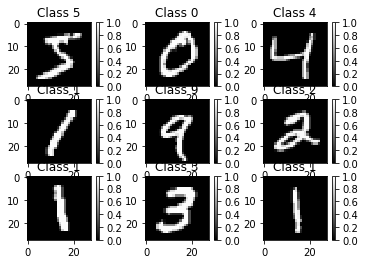

In [5]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray'); plt.colorbar()
    plt.title("Class {}".format(y_train[i]))

In [8]:
# Add a new axis so it has a 1D for the colorchannels.
X_train = X_train[:,:,:,np.newaxis]
print(X_train.shape)

(60000, 28, 28, 1)


In [10]:
# Change to 1-hot encoding.
Y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)
print(Y_train[:3])

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


Based on the example here:
https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/examples/tutorials/mnist/mnist_deep.py

In [11]:
def bias_variable(shape):
    """Generate a bais variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [12]:
def conv2d(x, W):
    """Return a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1,], padding='SAME')

In [13]:
def max_pool_2x2(x):
    """Downsample a feature map by 2x."""
    return tf.nn.max_pool(x, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

In [14]:
def weight_variable(shape):
    """Generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [40]:
# For the input image. 
# `None` represents the batch size, which will be determined at run-time.
# 28x28x1 represents the size of the input image.
x = tf.placeholder(tf.float32, [None, 28, 28, 1])

In [41]:
W_conv1 = weight_variable([5, 5, 1, 32]) # 5x5x1 filters with 32 feature maps.
b_conv1 = bias_variable([32]) # For the 32 feature maps.
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1) 
h_pool1 = max_pool_2x2(h_conv1)

In [42]:
W_conv2 = weight_variable([5, 5, 32, 64]) # 64 5x5x32 filters.
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [43]:
# We are down to 7x7x64 feature maps. Map this to 1024 features.
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [44]:
# Placeholder to specify the dropout rate.
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [45]:
# `10` since we have 10 output classes.
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

In [46]:
# This holds the unnormalized probabilites for the 10 classes.
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# This holds the true labels (where `None` is for the batch size determined at runtime)
y_ = tf.placeholder(tf.float32, [None, 10])

In [47]:
# This computes the loss.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

In [48]:
# Specify the optimizer and learning rate (1e-4).
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [49]:
# Compute accuracy over some input data.
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [56]:
# How many times to iterate over all the samples.
num_epochs = 10

# How many samples are there.
num_samples = 1000 #len(X_train)

# How many samples to include in a single batch (num_samples/batch_size) be an integer.
batch_size = 50

# What probability to keep responses in dropout.
dropout_prob = 0.5

# Setup a tensorflow session.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in xrange(num_epochs):
        # Gets the mini-batches.
        for idx in np.arange(0, num_samples, batch_size):
            # print(idx, idx + batch_size)
            batch_x = X_train[idx:idx+batch_size]
            batch_y = Y_train[idx:idx+batch_size]
            
            # Train the model.
            sess.run(train_step, feed_dict={x: batch_x, y_:batch_y, keep_prob: dropout_prob})
            
        # Compute the accuracy over the training data.
        train_accuracy = accuracy.eval(feed_dict={x: batch_x, y_: batch_y, keep_prob: dropout_prob})
        print('epoch %d, train acc %g' % (epoch, train_accuracy))
        
    # Compute the accuracy over the training data.
    test_accuracy = accuracy.eval(feed_dict={x: X_test[:batch_size,:,:,np.newaxis], y_: Y_test[:batch_size], keep_prob: dropout_prob})
    print('final epoch %d, test acc %g' % (epoch, test_accuracy))

epoch 0, train acc 0.24
epoch 1, train acc 0.34
epoch 2, train acc 0.54
epoch 3, train acc 0.62
epoch 4, train acc 0.74
epoch 5, train acc 0.84
epoch 6, train acc 0.8
epoch 7, train acc 0.82
epoch 8, train acc 0.82
epoch 9, train acc 0.78
final epoch 9, test acc 0.7
